In [1]:
import pandas as pd
import numpy as np
import pandas as pd
# import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', None)

root_dir = "/home/radar-data/radar_data/"

In [2]:
# Load the CSV file into a DataFrame
df = pd.read_csv(sorted(glob(root_dir + 'csv_files/*.csv'))[0])

# Get unique latitudes and longitudes
unique_latitudes = df['latitude'].unique().size
unique_longitudes = df['longitude'].unique().size

In [3]:
# Load CSV files
csv_files = sorted(glob(root_dir + 'csv_files/*.csv'))

def csv_to_grid(file_path):
    df = pd.read_csv(file_path)

    # Replace 'unknown' values that are 15 or smaller with 0
    df['unknown'] = df['unknown'].apply(lambda x: max(x, 0) if x > 15 else 0)
    
    # Ensure your radar data has the correct latitude/longitude ranges.
    grid = df.pivot(index='latitude', columns='longitude', values='unknown').values
    
    # Check if the grid has the correct shape (1018, 1018)
    if grid.shape != (unique_latitudes, unique_longitudes):
        raise ValueError(f"Grid shape mismatch in file {file_path}. Expected ({unique_latitudes}, {unique_longitudes}), got {grid.shape}")
    
    return grid

In [4]:
# Create input sequences and target sequences
sequence_length = 20 # e.g., number of csv files to look back on
prediction_horizon = 20 # number of csv files to predict
height, width = unique_latitudes, unique_longitudes

# Create 5D tensors for input and output, adding a channel dimension
X = []
y = []
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

print(len(csv_files) - sequence_length - prediction_horizon + 1)
for i in range(len(csv_files) - sequence_length - prediction_horizon + 1):
    print(i)
    input_sequence = [csv_to_grid(csv_files[j]) for j in range(i, i + sequence_length)]
    output_sequence = [csv_to_grid(csv_files[j]) for j in range(i + sequence_length, i + sequence_length + prediction_horizon)]
    
    # Reshape input and output sequences to add a channel dimension (reflectivity as 1 channel)
    input_sequence = np.array(input_sequence).reshape(sequence_length, height, width, 1)  # (sequence_length, height, width, 1)
    output_sequence = np.array(output_sequence).reshape(prediction_horizon, height, width, 1)  # (prediction_horizon, height, width, 1)
    
    X.append(input_sequence)
    y.append(output_sequence)

X = np.array(X)  # shape: (num_samples, sequence_length, height, width, 1)
y = np.array(y)  # shape: (num_samples, prediction_horizon, height, width, 1)

# First split: train and temp (which will later be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=(1 - train_ratio), random_state=42, shuffle=True
)

# Second split: validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42, shuffle=True
)

X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255
y_train = y_train / 255
y_val = y_val / 255
y_test = y_test / 255


380
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

Displaying frames for example 117.


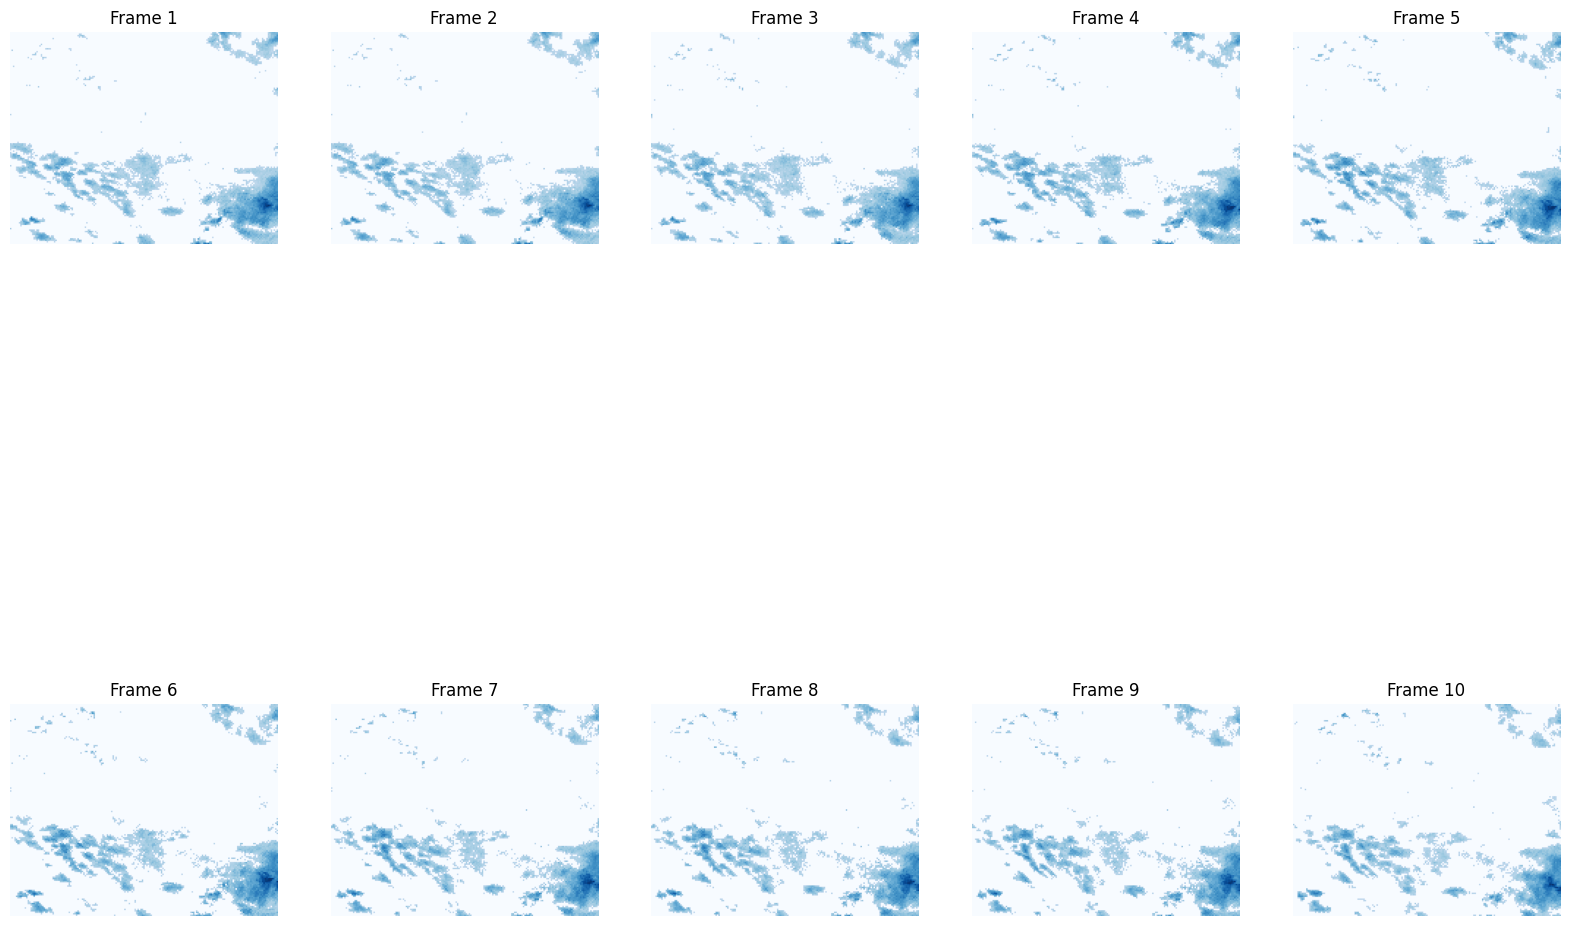

In [5]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 5, figsize=(20, 16))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(X_train)), size=1)[0]
lastdata = None  # Initialize lastdata to None before looping

for idx, ax in enumerate(axes.flat):
    thisdata = X_train[data_choice][idx]
    
    # Compare the current data to the last one if lastdata is not None
    if lastdata is not None and np.array_equal(thisdata, lastdata):
        print(f"Frame {idx} is the same as the previous frame.")
    
    # Display the image
    ax.imshow(np.squeeze(thisdata), cmap="Blues")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
    
    # Update lastdata
    lastdata = thisdata

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv3D, BatchNormalization, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

channels = 1  # Reflectivity is your feature, so 1 channel

# Define the model using an Input layer for the input shape
model = Sequential()

# Add Input Layer
model.add(Input(shape=(sequence_length, height, width, channels))) 

# First ConvLSTM2D layer with return_sequences=True
model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=True))
model.add(BatchNormalization())

# Second ConvLSTM2D layer with return_sequences=True to return all frames
model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=True))
model.add(BatchNormalization())

# Replace Conv3D with Conv2D to predict the next frame(s)
model.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation='linear', padding='same'))

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Print model summary
model.summary()

2024-10-01 03:34:12.560762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 03:34:12.574997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 03:34:12.579317: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 03:34:12.591102: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 03:34:13.323716: W tensorflow/compiler/tf2

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 145, 183,   │       150,016 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 145, 183,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 145, 183,   │       295,168 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 145, 183,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 20, 145, 183,   │         1,729 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 447,425 (1.71 MB)

 Trainable params: 447,169 (1.71 MB)

 Non-trainable params: 256 (1.00 KB)

In [7]:
# necessary to reshape the data to match model requirements
# X_train = tf.pad(X_train, [[0, 0], [0, 0], [0, 0], [1, 1], [0, 0]]) 
# y_train = tf.pad(y_train, [[0, 0], [0, 0], [0, 0], [1, 1], [0, 0]]) 
# X_val = tf.pad(X_val, [[0, 0], [0, 0], [0, 0], [1, 1], [0, 0]]) 
# y_val = tf.pad(y_val, [[0, 0], [0, 0], [0, 0], [1, 1], [0, 0]]) 
# X_test = tf.pad(X_test, [[0, 0], [0, 0], [0, 0], [1, 1], [0, 0]]).numpy()
# y_test = tf.pad(y_test, [[0, 0], [0, 0], [0, 0], [1, 1], [0, 0]]).numpy()

In [8]:
# model = load_model(root_dir + 'model/model6.keras')

In [9]:
cp = ModelCheckpoint(root_dir + 'model/model6_1.keras', save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=5)

# Train the model
model.fit(X_train, y_train, 
          batch_size=4, 
          epochs=20, 
          callbacks=[cp, early_stopping, reduce_lr],
          validation_data=(X_val, y_val))

Epoch 1/20


I0000 00:00:1727753659.646846   19881 service.cc:146] XLA service 0x62a329bb0d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727753659.646878   19881 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1727753659.646882   19881 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-01 03:34:19.760866: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-01 03:34:20.118773: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1727753664.340831   19881 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 333ms/step - loss: 0.4809 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - loss: 0.0031 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - loss: 0.0024 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - loss: 0.0020 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - loss: 0.0018 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - loss: 0.0017 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - loss: 0.0015 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - loss: 0.0015 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - loss: 0.0014 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


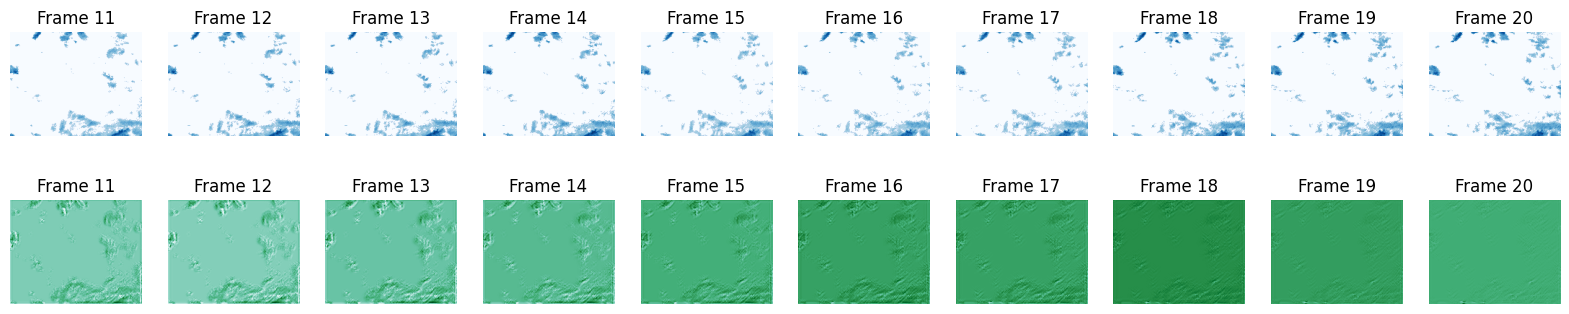

In [18]:
# Select a random example from the validation dataset.
example = X_val[np.random.choice(range(len(X_val)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="Blues")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="BuGn")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

In [19]:
# X_test = tf.pad(X_test, [[0, 0], [0, 0], [0, 0], [1, 1], [0, 0]]).numpy()
# y_test = tf.pad(y_test, [[0, 0], [0, 0], [0, 0], [1, 1], [0, 0]]).numpy()
print(f"X_train {X_train.shape}")
print(f"X_val {X_val.shape}")
print(f"X_test {X_test.shape}")

X_train (265, 20, 145, 183, 1)
X_val (57, 20, 145, 183, 1)
X_test (58, 20, 145, 183, 1)


In [20]:
# Select a few random examples from the dataset.
examples = X_test[np.random.choice(range(len(X_test)), size=1)]


# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", duration=200)
            predicted_videos.append(gif.getvalue())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [21]:
# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction
